In [6]:
import pandas as pd
import matplotlib.pylab as plt
from itertools import cycle

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [163]:
pd.set_option('display.max_columns', 500)

# Load and Proccess Dataset

In [149]:
df = pd.read_csv('./data/tweets.csv')

In [150]:
df.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩


In [151]:
df.shape

(234186, 5)

In [152]:
def proccess_tweets(df):
    df["tweet_datetime"] = pd.to_datetime(df["tweet_date"])
    df["tweet_date"] = df["tweet_datetime"].dt.date
    df["n_attempts"] = df["tweet_text"].str[11].astype("int")
    df["wordle_id"] = df["tweet_text"].str[:10]
    df["id"] = df["tweet_text"].str[7:10].astype("int")

    return df

df = proccess_tweets(df)

# How many tweets do we have for each date

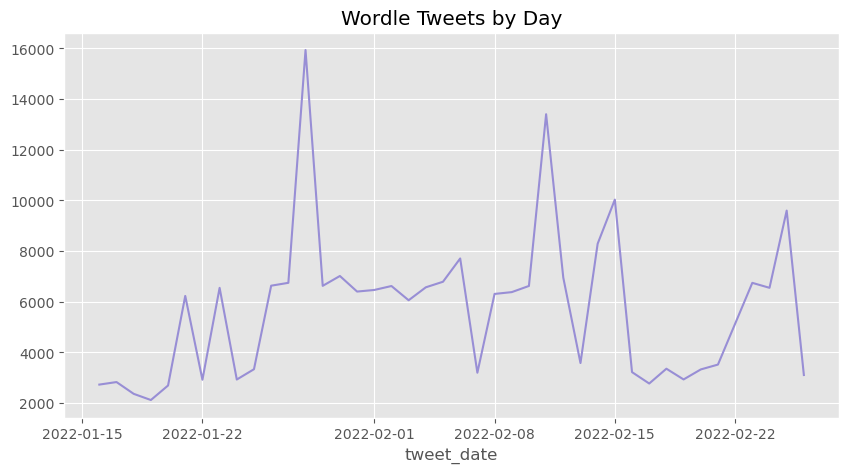

In [153]:
df["tweet_date"].value_counts() \
    .plot(
        figsize=(10,5),
        title="Wordle Tweets by Day",
        color=color_pal[2]
    )

plt.show()

# Number of Attempts analysis

In [154]:
df.columns

Index(['wordle_id', 'tweet_id', 'tweet_date', 'tweet_username', 'tweet_text',
       'tweet_datetime', 'n_attempts', 'id'],
      dtype='object')

In [155]:
df.groupby("wordle_id")["n_attempts"].value_counts().unstack() \
    .style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
Wordle 210,222,897,1064,489,165
Wordle 211,196,903,1016,564,215
Wordle 212,191,787,820,413,188
Wordle 213,51,260,630,697,481
Wordle 214,383,1012,823,363,122
Wordle 215,246,877,1017,579,224
Wordle 216,461,1952,2078,1199,415
Wordle 217,102,566,1031,843,418
Wordle 218,170,1009,1384,730,187


# How many attempts does it ussually take to solve wordle?

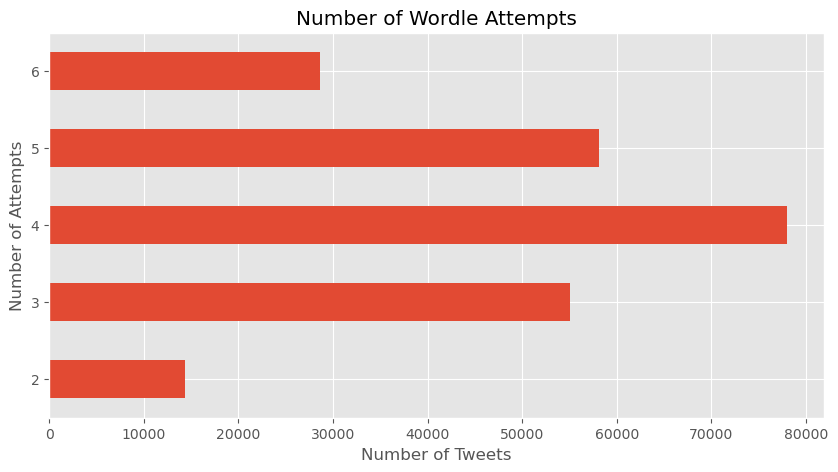

In [156]:
df["n_attempts"].value_counts() \
    .sort_index() \
    .plot(
        kind="barh",
        figsize=(10,5),
        title="Number of Wordle Attempts",
        ylabel="Number of Attempts",
        xlabel="Number of Tweets"
    )

plt.show()

# Parse tweets text

In [157]:
df["tweet_text"] = df["tweet_text"].str.replace("⬜", "⬛")

In [158]:
for n in range(6):
    n+=1
    df[f"has_guess{n}"] = df["tweet_text"].str.split("\n").str[n+1] \
        .str.contains("|".join(["🟨", "⬛", "🟩"])) \
        .fillna(False)

    df.loc[df[f"has_guess{n}"], f"guess{n}"] = df["tweet_text"].str.split("\n", expand=True)[n+1]

    df.loc[df[f"has_guess{n}"], f"guess{n}_incorrect"] = df[f"guess{n}"].str.count("⬛")
    df.loc[df[f"has_guess{n}"], f"guess{n}_wrong_spot"] = df[f"guess{n}"].str.count("🟨")
    df.loc[df[f"has_guess{n}"], f"guess{n}_correct"] = df[f"guess{n}"].str.count("🟩")

    df.loc[df[f"guess{n}_correct"] == 6, "final_guess"] = n

In [172]:
df["additional_text"] = df[~df["tweet_text"].str.split("\n").str[-1].str.contains("🟩")] \
    ["tweet_text"].str.split("\n").str[-1]

# Plot Result by attempt

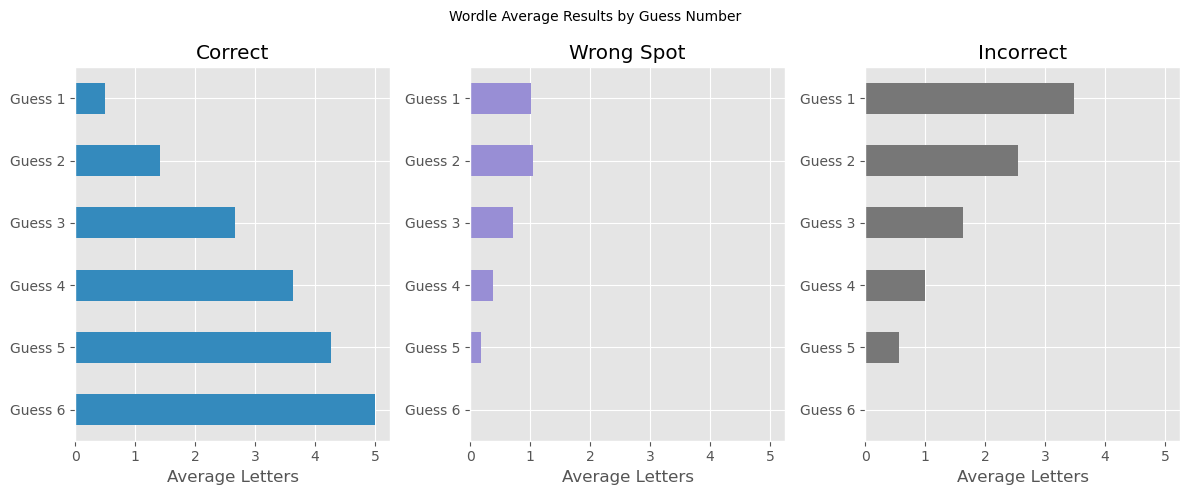

In [211]:
fig, axs = plt.subplots(1, 3, figsize=(12,5), sharex=True)

for i, x in enumerate(["_correct", "_wrong_spot", "_incorrect"]):
    col_subset = [c for c in df.columns if x in c]
    guess_avg = df[col_subset].mean()
    guess_avg.index = [f"Guess {i+1}" for i in range(6)]
    guess_avg.sort_index(ascending=False) \
        .plot(
            kind="barh",
            title=f"{x.strip('_').replace('_', ' ').title()}",
            ax=axs[i],
            color=color_pal[i+1] 
        )
    axs[i].set_xlabel("Average Letters")

fig.suptitle("Wordle Average Results by Guess Number", fontsize=10)
plt.tight_layout()
plt.show()